**Table of Contens:**
- 简述
- 导入CIFAR10数据集
- 简要介绍神经网络算法
- 实现细节
- 训练模型
- 预测模型

## 简述

在本次项目中，我们将在 CIFAR-10 数据集上，使用 pytorch 实现一个二层神经网络的分类算法。具体步骤如下：
- 建立目标函数：通过前向传播计算损失。
- 计算梯度并优化参数：通过反向传播计算梯度，对模型参数进行优化。
- 使用模型预测：使用训练数据集对模型进行预测。

## 导入CIFAR10数据集

>数据集介绍:
>CIFAR-10 是一个常用的计算机视觉数据集，全称为 Canadian Institute For Advanced Research 10-class dataset。这个数据集由 60000 张 32x32 彩色图像组成，分为 10 个类别，每个类别有 6000 张图像。这些图像均衡地分布在各个类别中，主要用于图像分类任务

首先先导入必要的 python 依赖，可以通过`pip install -r requirements.txt`下载依赖

In [1]:
import utils
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math

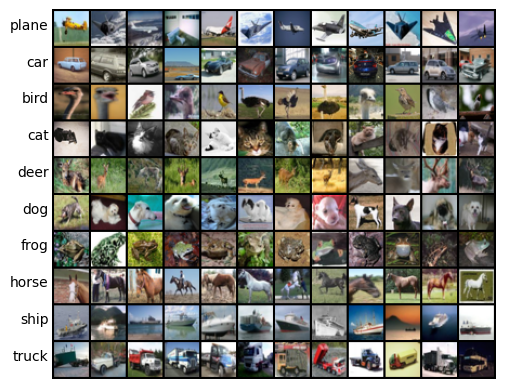

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [2]:
# 设置随机种子确保实验结果可重复
utils.reset_seed(0)
# 导入数据集
data_dict = utils.data.preprocess_cifar10(dtype=torch.float64)
# 输出数据集形状
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

我们简单介绍一下这个数据：
- 图片一共被分为了飞机，汽车，鸟等等共10类。
- 40000个训练集，10000个验证集，10000个测试集
- 我将一个32×32×3的图片展平成3072，因此数据集是二维的 （40000, 3072）

## 简要介绍神经网络算法

>神经网络算法是一种机器学习方法，模仿人脑的神经元网络结构进行建模。它由多层神经元组成，每一层通过权重和偏置调整输入数据，逐层处理并提取特征
神经网络算法与其他人工智能算法类似，通常由以下三个主要部分组成：每层神经元通过激活函数进行非线性变换，使得网络可以学习复杂的模式和特征。通过反向传播算法，神经网络可以优化权重和偏置，使得网络输出尽可能接近真实值，从而实现分类、回归或其他预测任务。

神经网络算法与其他人工智能算法类似，通常由以下三个主要部分组成：
- 假设空间 (Hypothesis Class)：定义了模型可以表达的所有可能函数形式。
- 损失函数 (Loss Function)：衡量模型预测与实际结果之间的差异。
- 优化算法 (Optimization)：用于调整模型参数，使得损失函数最小化。

因此一个这个模型应该包括计算损失，训练，预测等功能，伪代码如下
``` python
class TwoLayerNet(object):
    def loss(...):
        # 计算损失函数
        pass

    def train(...):
        # 训练模型，并使用优化算法调整参数
        pass
    
    def predict(...):
        # 预测模型的输出
        pass

    def save(...):
        # 保存模型
        pass

    def load (...)"
        # 加载模型
        pass
```

具体实现细节：
- 使用 softmax 作为损失函数
- 使用梯度下降SGD反向传播算法优化参数

公式如下：
$$\text{minimize} ~~ \ell_{\mathrm{softmax}} ~ (\mathrm{ReLU}(X W_1 + b_1) W_2 + b_2, y)$$

## 实现细节

### 前向传播，计算 scores

给定一张图片，我们可以根据以下公式计算它分别属于10个类别的分数。

$$z = (X W_1 + b_1) W_2 + b_2$$

input layer -> ReLU (hidden) -> output layer (scores)

![image.png](./images/SCR-20240705-loso.png)

python 实现如下
```python
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    N, D = X.shape

    # first layer
    hidden = X.mm(W1) + b1 # (N, D) * (D, H) + (H,)
    hidden[hidden < 0] = 0 # relu

    # second layer
    scores = hidden.mm(W2) + b2 # (N, H) * (H, C) + (C,)
```

### softmax 损失函数

反向传播第一步是计算损失函数，我们选取softmax损失函数。其计算公式如下：

$$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}$$

python 实现如下
```python
    scores = scores - scores.max(1, True).values # normalization
    softmax = scores - scores.logsumexp(1, True) # one row loss
    loss = -softmax[range(N), y].mean() # mean 

    # regularization
    loss += reg * torch.sum(W1 * W1) + reg * torch.sum(W2 * W2)
```

### 计算梯度

$$\nabla_\Theta \ell_{\mathrm{softmax}}(X \Theta, y) = \frac{1}{m} X^T (Z - I_y)$$

由于我们的参数有W_1, W_2, b_1, b_2，因此我们需要分别计算 W_1, W_2, b_1, b_2 的梯度, 梯度通过反向传播算法（即导数的链式求导法则）来计算, 这里不详细讨论。
![image.](./images/SCR-20240705-ltqw.png)

python实现如下
```python
    prob = softmax.exp() # (N, C)
    prob[torch.arange(N), y] -= 1
    prob /= N
    
    grads['b2'] = prob.sum(0) # (C, )
    grads['W2'] = h1.T.mm(prob) + reg * 2 * W2  # (H, C)

    # Relu gradient
    grads_h1 = prob.mm(W2.t())
    grads_h1[h1 <= 0] = 0

    grads['b1'] = grads_h1.sum(0)
    grads['W1'] = X.T.mm(grads_h1) + 2 * reg * W1
```

### 随机梯度下降

随机梯度下降每次只使用一部分样本 (batch) 来计算梯度和更新参数，而不是使用整个数据集。这使得SGD每次迭代的计算量更小，更新速度更快，适合处理大型数据集。一次迭代称之为 epoch

python 实现
```python
    for it in range(num_iters):
        X_batch, y_batch = sample_batch(X, y, num_train, batch_size)

        # Compute loss and gradients using the current minibatch
        loss, grads = loss_func(params, X_batch, y=y_batch, reg=reg)
        loss_history.append(loss.item())

        # update parameter
        params['W1'] -= learning_rate * grads['W1']
        params['b1'] -= learning_rate * grads['b1']
        params['W2'] -= learning_rate * grads['W2']
        params['b2'] -= learning_rate * grads['b2']
```

### hyper-parameter

在神经网络算法中，超参数（Hyper-parameters）是指那些在训练过程中不会更新的参数，而是需要在训练之前手动设置的参数。在我们这个二层神经网络模型中，超参数有：
- learning_rates
- hidden_sizes
- regularization_strengths
- learning_rate_decays

由于我们的损失函数并没有考虑的超参数的影响，求导优化也就无从谈起。因此我们需要反复调整这些超参数来获取最佳组合，

```python
    # ...
    for learning_rate in learning_rates:
      for hidden_size in hidden_sizes:
        for reg in regularization_strengths:
          for learning_rate_decay in learning_rate_decays:
            # train, get accuracy
    
    # compare and get best
```

## 训练模型

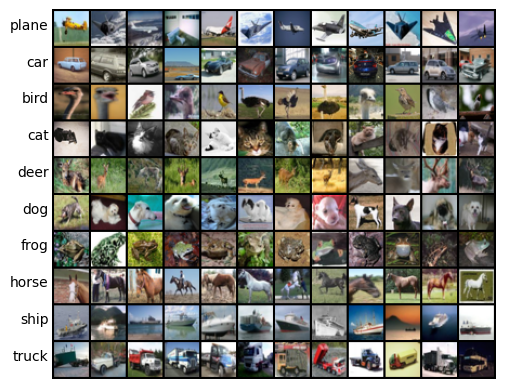

train with hyperparameters: lr = 1.0, hs = 1024, reg = 0.001, lr_decay = 0.97: val_acc = 0.5594000220298767
hyperparameters with best model: lr = 1.0, hs = 1024, reg = 0.001, lr_decay = 0.97
0.5594000220298767


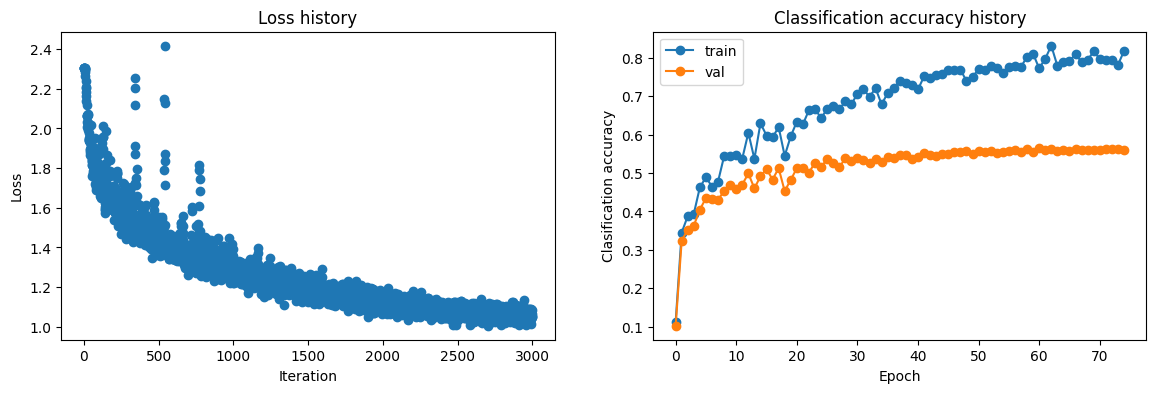

Saved in ./nn_best_model.pt


In [3]:
import os
import utils
from utils.plot import plot_stats
from two_layer_net import TwoLayerNet, find_best_net, nn_get_search_params

# 使用 float32 类型来减少训练时间
utils.reset_seed(0)
data_dict = utils.data.preprocess_cifar10(dtype=torch.float32)

# ==此处为了演示速度我直接选取了目前最好的超参数组合==

# 寻找出最好的预设参数
utils.reset_seed(0)
best_net, best_stat, best_val_acc = find_best_net(data_dict, nn_get_search_params)
print(best_val_acc)

plot_stats(best_stat)

# save the best model
path = os.path.join('.', 'nn_best_model.pt')
best_net.save(path)

In [4]:
# 在验证集上测试模型准确率
y_val_preds = best_net.predict(data_dict['X_val'])
val_acc = 100 * (y_val_preds == data_dict['y_val']).double().mean().item()
print('Best val-set accuracy: %.2f%%' % val_acc)

Best val-set accuracy: 56.38%


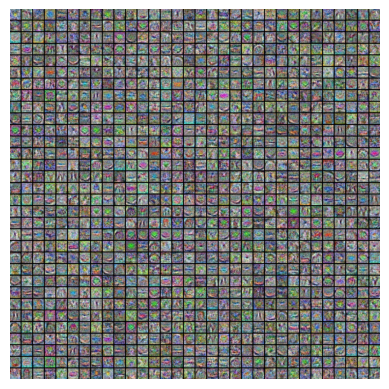

In [5]:
from utils.plot import show_net_weights
# 可视化权重
show_net_weights(best_net)

## 模型预测

In [ ]:
# 在测试集上测试模型准确率

# 预测测试集准确率
y_test_preds = best_net.predict(data_dict['X_test'])
test_acc = 100 * (y_test_preds == data_dict['y_test']).double().mean().item()
print('Test accuracy: %.2f%%' % test_acc)

Test accuracy: 55.62%


Image 1: True label - cat, Predicted label - cat
Image 2: True label - dog, Predicted label - dog
Image 3: True label - frog, Predicted label - frog
Image 4: True label - ship, Predicted label - airplane
Image 5: True label - horse, Predicted label - truck


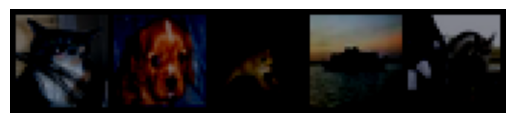

In [7]:
from utils.utils import visualize_dataset

# class 种类
class_list = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

rand_num = 5

# 从测试集中随机选取 5 张图片
random.seed(0)  # Set random seed for reproducibility
indices = random.sample(range(len(data_dict['X_test'])), rand_num)

images = data_dict['X_test'][indices] # shape torch.Size([5, 3072])
labels = data_dict['y_test'][indices]

# 对比预测结果和真实标签
predicted_labels = best_net.predict(images)
for i in range(len(images)):
    print(f"Image {i+1}: True label - {class_list[labels[i]]}, Predicted label - {class_list[predicted_labels[i]]}")

# 输出这五张图片
images = images.view(5, 3, 32, 32)
img = torchvision.utils.make_grid(images, nrow=5)
plt.imshow(utils.tensor_to_image(img))
plt.axis("off")
plt.show()